ESILV Academic Assistant - Evaluation Notebook

In [1]:
import os
import sys
import time
import json
import logging
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import asyncio
import scraper
from concurrent.futures import ThreadPoolExecutor

In [2]:
!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Set MOCK_SCRAPER to False if you have valid De Vinci credentials and want REAL testing.
Set to True to test agent logic with fake data (faster, no network needed).

In [3]:
MOCK_SCRAPER = False

In [4]:
try:
    from agent import ReActAgent, create_llm
    from tools import set_credentials, get_courses, get_deadlines
    print("Project modules loaded successfully.")
except ImportError as e:
    print(f"Import Error: {e}")
    print("Ensure 'agent.py', 'tools.py', and 'scraper.py' are in the same directory.")
    sys.exit(1)

c:\Users\alanc\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Project modules loaded successfully.


In [5]:
# Initialize LLM
MODEL_NAME = "gemma3:4b"
try:
    llm_instance = create_llm(MODEL_NAME) if create_llm else None
    print(f"✅ LLM ({MODEL_NAME}) initialized.")
except Exception as e:
    print(f"⚠️ Error initializing LLM: {e}")
    llm_instance = None

✅ LLM (gemma3:4b) initialized.


Mocking the Scraper (If needed)

If MOCK_SCRAPER is True, this replaces the real Playwright call.

In [6]:
async def mock_get_courses():
    return  """ 📚 Data Protection management (Informatique)    ➡️ Progression du cours : 3 % terminé
                📚 Spark for Big data (Informatique)            ➡️ Progression du cours : 0 % terminé
                📚 Big data structure (Informatique)            ➡️ Progression du cours : 20 % terminé
                📚 Machine Learning (Informatique)              ➡️ Progression du cours : 45 % terminé
                📚 Soft-skills & Leadership (Skills)            ➡️ Progression du cours : 75 % terminé
                📚 Thesis Methodology (Multidisciplinaire)      ➡️ Progression du cours : 90 % terminé
            """

async def mock_get_deadlines():
    return """⏰ Aujourd'hui 17:00 - Project submission
              ⏰ Vendredi 09:00 - Quiz 3"""

def safe_get_courses(email=None, password=None):
    if MOCK_SCRAPER:
        # Run async mock in new event loop for sync call
        return asyncio.run(mock_get_courses())
    else:
        # Call real scraper with credentials
        return scraper.get_courses_blocking(email, password)

def safe_get_deadlines(email=None, password=None):
    if MOCK_SCRAPER:
        return asyncio.run(mock_get_deadlines())
    else:
        # Call real scraper with credentials
        return scraper.get_deadlines_blocking(email, password)

In [7]:
ground_truth = [
    {
        "query": "List all my courses related to Data.",
        "expected_tool": "get_courses",
        "expected_keywords": ["Spark", "Big data", "Machine Learning"],
        "expected_count_min": 1
    },
    {
        "query": "What are my deadlines?",
        "expected_tool": "get_deadlines",
        "expected_keywords": ["Project", "Quiz"],
        "expected_count_min": 1
    },
    {
        "query": "Tell me about my courses that are unrelated to Data and IA.",
        "expected_tool": "get_courses",
        "expected_keywords": ["Methodology", "Soft-Skills"],
        "expected_count_min": 1
    }
]

ReAct Agent Class (Standalone definition)

In [8]:
if ReActAgent:
    # Set up credentials for tools (optional, for real testing)
    set_credentials("alan.casasnovas@edu.devinci.fr", "SILKSONGccool92")
    
    agent = ReActAgent(
        llm=llm_instance,
        tools_list=[get_courses, get_deadlines]
    )
    print("✅ ReActAgent initialized (using imported class).")

✅ ReActAgent initialized (using imported class).


The Evaluation Loop

In [9]:
results = []

print(f"{'='*50}")
print(f"Starting Evaluation with {len(ground_truth)} queries on Model: {MODEL_NAME}")
print(f"Scraper Mock Status: {'ENABLED' if MOCK_SCRAPER else 'DISABLED'}")
print(f"{'='*50}")

def run_in_thread(func, *args, **kwargs):
    """
    Runs a synchronous function in a separate thread.
    This isolates the event loop created by scraper.py from Jupyter's event loop.
    """
    with ThreadPoolExecutor() as executor:
        future = executor.submit(func, *args, **kwargs)
        return future.result()

for i, gt in enumerate(ground_truth):
    print(f"\n--- Case {i+1}: {gt['query']} ---")
    
    start_time = time.time()
    
    # Run Agent
    try:
        response = run_in_thread(agent.invoke, gt['query'])
    except Exception as e:
        print(f"Error running agent: {e}")
        response = f"Error: {e}"
    
    end_time = time.time()
    total_latency = end_time - start_time
    
    print(f"⏱️ Latency: {total_latency:.2f} s")
    print(f"📝 Agent Response: {response}")

    # Parse Response & Metrics
    # We check if the correct tool was invoked.
    # Heuristic: Check output for "get_courses" or "get_deadlines" strings
    predicted_tool = "unknown"
    if "get_courses" in response:
        predicted_tool = "get_courses"
    elif "get_deadlines" in response:
        predicted_tool = "get_deadlines"
    
    # Check if expected keywords appear in response
    has_data = False
    if gt.get('expected_keywords'):
        # Case-insensitive keyword matching
        for keyword in gt['expected_keywords']:
            if keyword.lower() in response.lower():
                has_data = True
                break
    
    # Validate tool selection
    is_tool_correct = (predicted_tool == gt['expected_tool'])
    
    results.append({
        "query_id": i + 1,
        "query": gt['query'],
        "expected_tool": gt['expected_tool'],
        "predicted_tool": predicted_tool,
        "is_tool_correct": is_tool_correct,
        "has_expected_data": has_data,
        "latency": total_latency,
        "output": response
    })

Starting Evaluation with 3 queries on Model: gemma3:4b
Scraper Mock Status: DISABLED

--- Case 1: List all my courses related to Data. ---


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
INFO:agent:Agent thinking: Okay, I can help you with that. To list all your courses related to Data, I’m going to use the `get_courses()` tool to retrieve a complete list of all your courses. Then, I’ll review the list to ident
INFO:agent:🔧 Executing tool: get_courses


🔌 Connecting to Moodle...
✅ Connection successful.
📚 Extracting course list...
🔄 Checking display mode...
  ✅ Already in summary mode.
  -> Waiting for content to load...
✅ Retrieved 22 courses in summary view.


INFO:agent:✅ Tool result: 📚 Nom du cours
Gen AI (MESIIN594525) (Informatique) - Progression du cours :
44 %
📚 Nom du cours
CV and Deep Learning (MESIIN595125) (Informatique) - Progression du cours :
10 %
📚 Nom du cours
Machine
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


⏱️ Latency: 451.59 s
📝 Agent Response: Okay, I’ve retrieved a list of all your courses from De Vinci Moodle. Here’s a breakdown of the courses that relate to Data, based on their titles:

*   **CV and Deep Learning** (MESIIN595125) (Informatique)
*   **Machine learning** (MESIIN595625) (Informatique)
*   **Explainability AI** (MESIIN595325) (Informatique)
*   **LLM and GenAI** (MESIIN595025) (Informatique)
*   **Big data structure** (MESIIN596525) (Informatique)
*   **Graph and mining** (MESIIN594425) (Informatique)
*   **Data protection management** (MESIIN594125) (Informatique)
*   **Spark for Big data** (MESIIN595225) (Informatique)
*   **BI Pipeline** (MESIIN595525) (Informatique)

Do you have any questions about these courses, or would you like me to look for deadlines associated with them?

--- Case 2: What are my deadlines? ---


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
INFO:agent:Agent thinking: Okay, I can help you with that! To find out your upcoming deadlines, I’m going to use the `get_deadlines()` tool. This tool will retrieve all assignment deadlines from our Moodle courses.

Let me run 
INFO:agent:🔧 Executing tool: get_deadlines


🔌 Connecting to Moodle...
✅ Connection successful.
🔍 Extracting timeline events...
  -> Waiting for content to load...
✅ Found 2 events.


INFO:agent:✅ Tool result: ⏰ Lundi 5 Janvier 2026 00:00 - Lab 10- Time-Series Forecasting - Part2
⏰ Samedi 10 Janvier 2026 00:00 - Homework Project Submission
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


⏱️ Latency: 196.69 s
📝 Agent Response: Okay, I can help you with that! To find out your upcoming deadlines, I’m going to use the `get_deadlines()` tool. This tool will retrieve all assignment deadlines from our Moodle courses.

Let me run that tool now…

…Okay, the tool has finished running. Here’s a list of your upcoming deadlines:

⏰ Lundi 5 Janvier 2026 00:00 - Lab 10- Time-Series Forecasting - Part2
⏰ Samedi 10 Janvier 2026 00:00 - Homework Project Submission

Do you want me to check the deadlines for a specific course, or would you like me to provide more detail about any of these assignments?

--- Case 3: Tell me about my courses that are unrelated to Data and IA. ---


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
INFO:agent:Agent thinking: Okay, I can definitely help you with that. To figure out which of your courses aren’t related to Data and IA, I’m going to need to see a list of all your courses.

I’ll use the `get_courses()` tool to
INFO:agent:🔧 Executing tool: get_courses


🔌 Connecting to Moodle...
✅ Connection successful.
📚 Extracting course list...
🔄 Checking display mode...
  ✅ Already in summary mode.
  -> Waiting for content to load...
✅ Retrieved 22 courses in summary view.


INFO:agent:✅ Tool result: 📚 Nom du cours
Gen AI (MESIIN594525) (Informatique) - Progression du cours :
44 %
📚 Nom du cours
CV and Deep Learning (MESIIN595125) (Informatique) - Progression du cours :
10 %
📚 Nom du cours
Machine
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


⏱️ Latency: 338.57 s
📝 Agent Response: Okay, I’ve retrieved a list of all your courses from De Vinci Moodle. Here’s a breakdown of the courses that don’t relate to Data or IA:

*   **Gen AI (MESIIN594525)** (Informatique) - 44%
*   **CV and Deep Learning (MESIIN595125)** (Informatique) - 10%
*   **Machine learning (MESIIN595625)** (Informatique) - 0%
*   **Project # (MESIGP59+125)** (Multidisciplinaire) - 5%
*   **Explainability AI (MESIIN595325)** (Informatique) - 50%
*   **LLM and GenAI (MESIIN595025)** (Informatique) - 10%
*   **Big data structure (MESIIN596525)** (Informatique) - 20%
*   **Graph and mining (MESIIN594425)** (Informatique) - 6%
*   **Marketing Yourself (MESISK590125)** (Skills) - 1%
*   **Security use cases (MESIIN594325)** (Informatique) - 0%
*   **Data protection management (MESIIN594125)** (Informatique) - 3%
*   **Spark for Big data (MESIIN595225)** (Informatique) - 0%
*   **Thesis methodology (MESIEI591525)** (Multidisciplinaire) - 0%
*   **BI Pipeline (MESIIN59

Metrics Calculation

In [10]:
# Calculate Global Metrics based on results
eval_results = []
for r in results:
    is_tp = r['is_tool_correct'] and r['has_expected_data']
    is_fp = r['is_tool_correct'] and not r['has_expected_data']
    is_fn = not r['is_tool_correct'] and r['has_expected_data']
    is_tn = not r['is_tool_correct'] and not r['has_expected_data']
    
    eval_results.append({
        "tp": is_tp,
        "fn": is_fn,
        "fp": is_fp,
        "tn": is_tn,
        "query": r['query']
    })

# Aggregate Precision/Recall
total_tp = sum(1 for r in eval_results if r['tp'])   # Count TPs
total_fp = sum(1 for r in eval_results if r['fp'])   # Count FPs
total_fn = sum(1 for r in eval_results if r['fn'])   # Count FNs
# Avoid division by zero
denom_p = total_tp + total_fp if total_tp > 0 else 1
denom_r = total_tp + total_fn if total_tp > 0 else 1

precision = total_tp / denom_p
recall = total_tp / denom_r
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\n" + "="*50)
print("OVERALL METRICS")
print("="*50)
print(f"Tool Selection Accuracy (Precision-like): {precision:.2%}") # % of queries where correct tool was used
print(f"Data Extraction Accuracy (Recall-like):   {recall:.2%}")   # % of queries where data was correctly retrieved
print(f"F1 Score:                                         {f1:.2f}")
print(f"Average Latency: {np.mean([r['latency'] for r in results]):.2f}s")


OVERALL METRICS
Tool Selection Accuracy (Precision-like): 100.00%
Data Extraction Accuracy (Recall-like):   33.33%
F1 Score:                                         0.50
Average Latency: 328.95s


Visualization

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


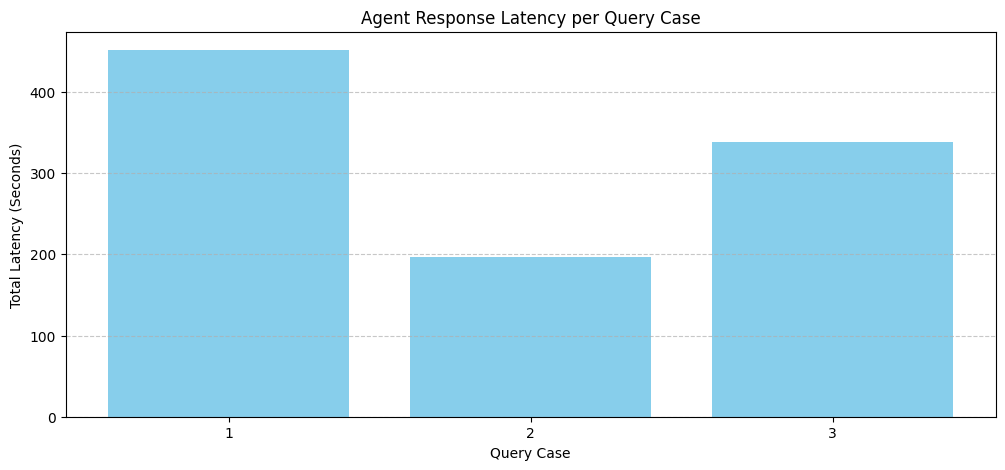

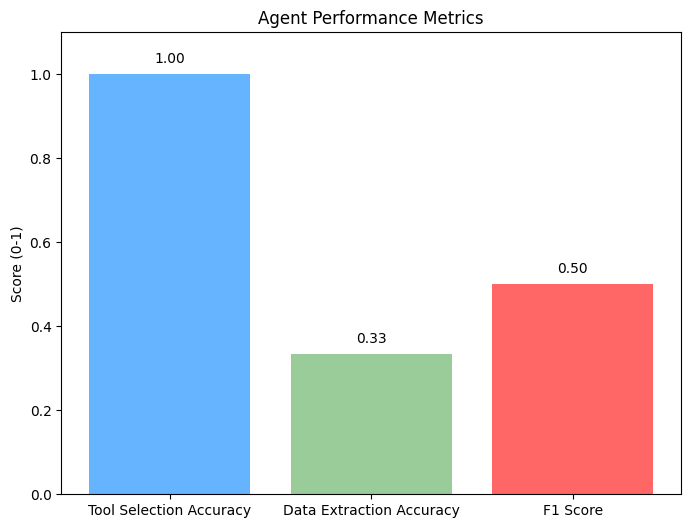

In [11]:
# Create DataFrame for easier plotting
df_results = pd.DataFrame(results)

# Chart 1: Total Latency per Query
plt.figure(figsize=(12, 5))
bars = plt.bar(df_results['query_id'].astype(str), df_results['latency'], color='skyblue')
plt.xlabel('Query Case')
plt.ylabel('Total Latency (Seconds)')
plt.title('Agent Response Latency per Query Case')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Chart 2: Metrics Overview (Precision, Recall, F1)
metrics = [precision, recall, f1]
labels = ['Tool Selection Accuracy', 'Data Extraction Accuracy', 'F1 Score']

plt.figure(figsize=(8, 6))
plt.bar(labels, metrics, color=['#66b3ff', '#99cc99', '#ff6666'])
plt.ylim(0, 1.1)
plt.ylabel('Score (0-1)')
plt.title('Agent Performance Metrics')

# Add value labels on bars
for i, v in enumerate(metrics):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom')
plt.show()